In [1]:
# taken from: https://gist.github.com/fepegar/c6163af3fcde2bad59207130ddd127d1#file-visualize-positional-embeddings-in-dinov2-vit-ipynb

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from einops import rearrange
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.models.components.partv3 import PARTMaskedAutoEncoderViT
from src.models.components.utils.pos_embed import get_2d_sincos_pos_embed
torch.set_grad_enabled(False);

In [3]:
pretrained = PARTMaskedAutoEncoderViT(embed_dim=768, depth=12, num_heads=12, decoder_num_heads=16).eval()

In [4]:
all_position_embeddings = pretrained.pos_embed
# From the code, we know the first embedding corresponds to the class token
patch_position_embeddings = all_position_embeddings[0][1:]
patch_position_embeddings.shape

torch.Size([196, 768])

In [5]:
patch_position_embeddings = torch.from_numpy(get_2d_sincos_pos_embed(768, 14, True)).unsqueeze(0)
patch_position_embeddings = patch_position_embeddings[0, 1:]
patch_position_embeddings.shape

torch.Size([196, 768])

In [6]:
num_tokens, dim = patch_position_embeddings.shape
num_tokens_y = num_tokens_x = int(np.sqrt(num_tokens))  # assume width = height
num_tokens_y

14

In [7]:
patch_pos_embed_grid = rearrange(patch_position_embeddings, '(h w) c -> c h w', h=num_tokens_y)
patch_pos_embed_grid.shape

torch.Size([768, 14, 14])

In [8]:
def compute_cosine_similarity_matrix(tensor):
    normalized_tensor = F.normalize(tensor, p=2, dim=1)
    cosine_similarity_matrix = torch.mm(normalized_tensor, normalized_tensor.t())
    return cosine_similarity_matrix

similarity_matrix = compute_cosine_similarity_matrix(patch_position_embeddings)
similarity_matrix.shape

torch.Size([196, 196])

In [9]:
similarities = []
for row in similarity_matrix:
    grid = rearrange(row, '(h w) -> h w', h=num_tokens_y)
    similarities.append(grid)
similarities = torch.stack(similarities)
similarities.shape

torch.Size([196, 14, 14])

In [10]:
similarities_for_grid = rearrange(similarities, 'n h w -> n 1 h w')
grid = torchvision.utils.make_grid(
    similarities_for_grid,
    nrow=num_tokens_x,
    pad_value=torch.nan,
    padding=int(num_tokens_x * 0.15),
)
grid.shape

torch.Size([3, 226, 226])

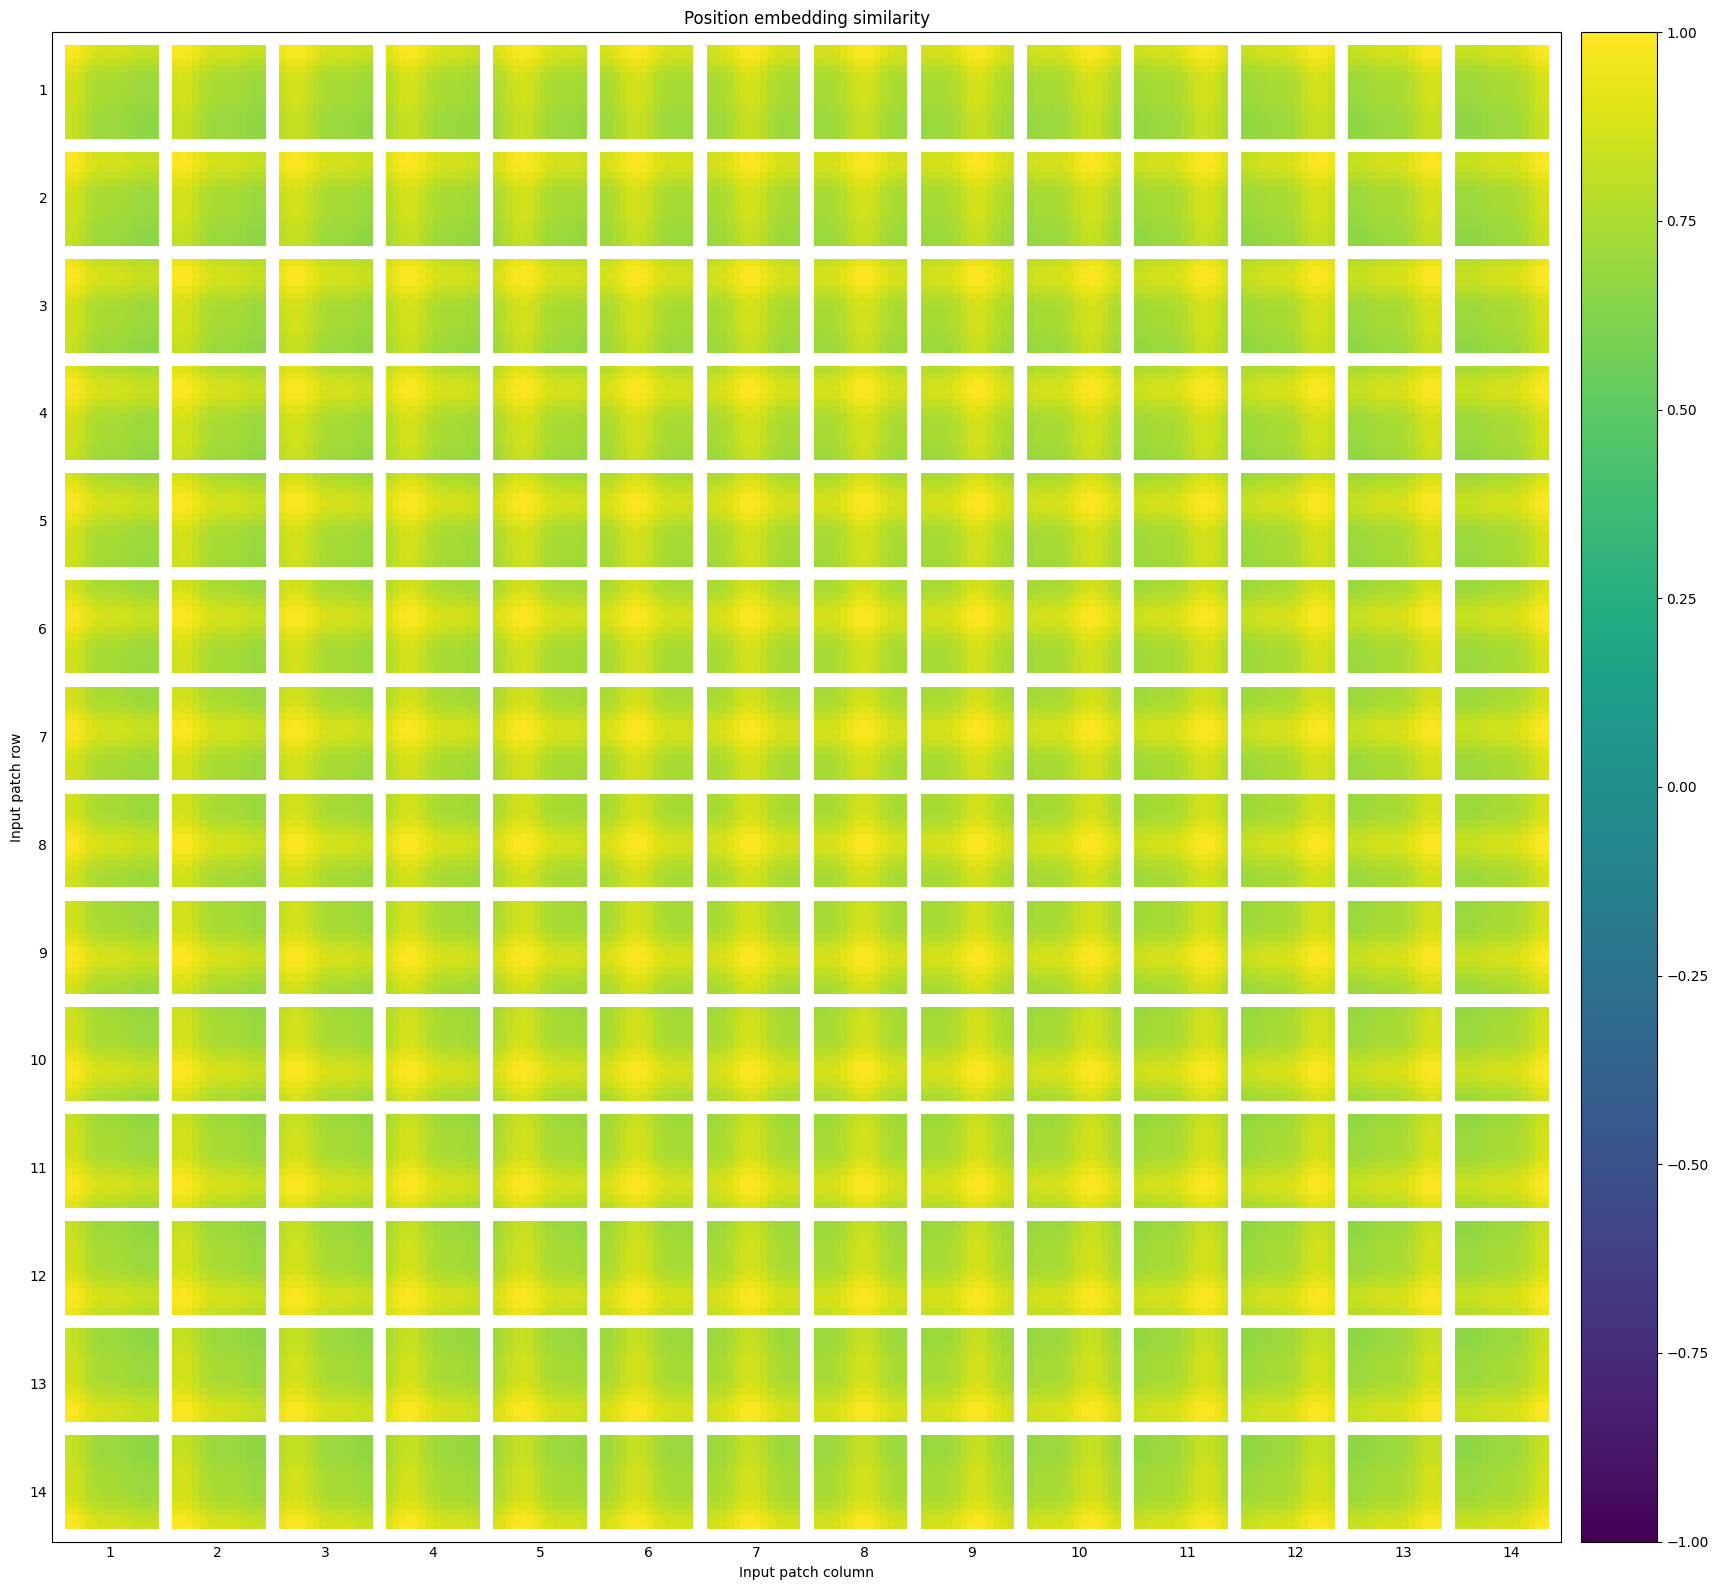

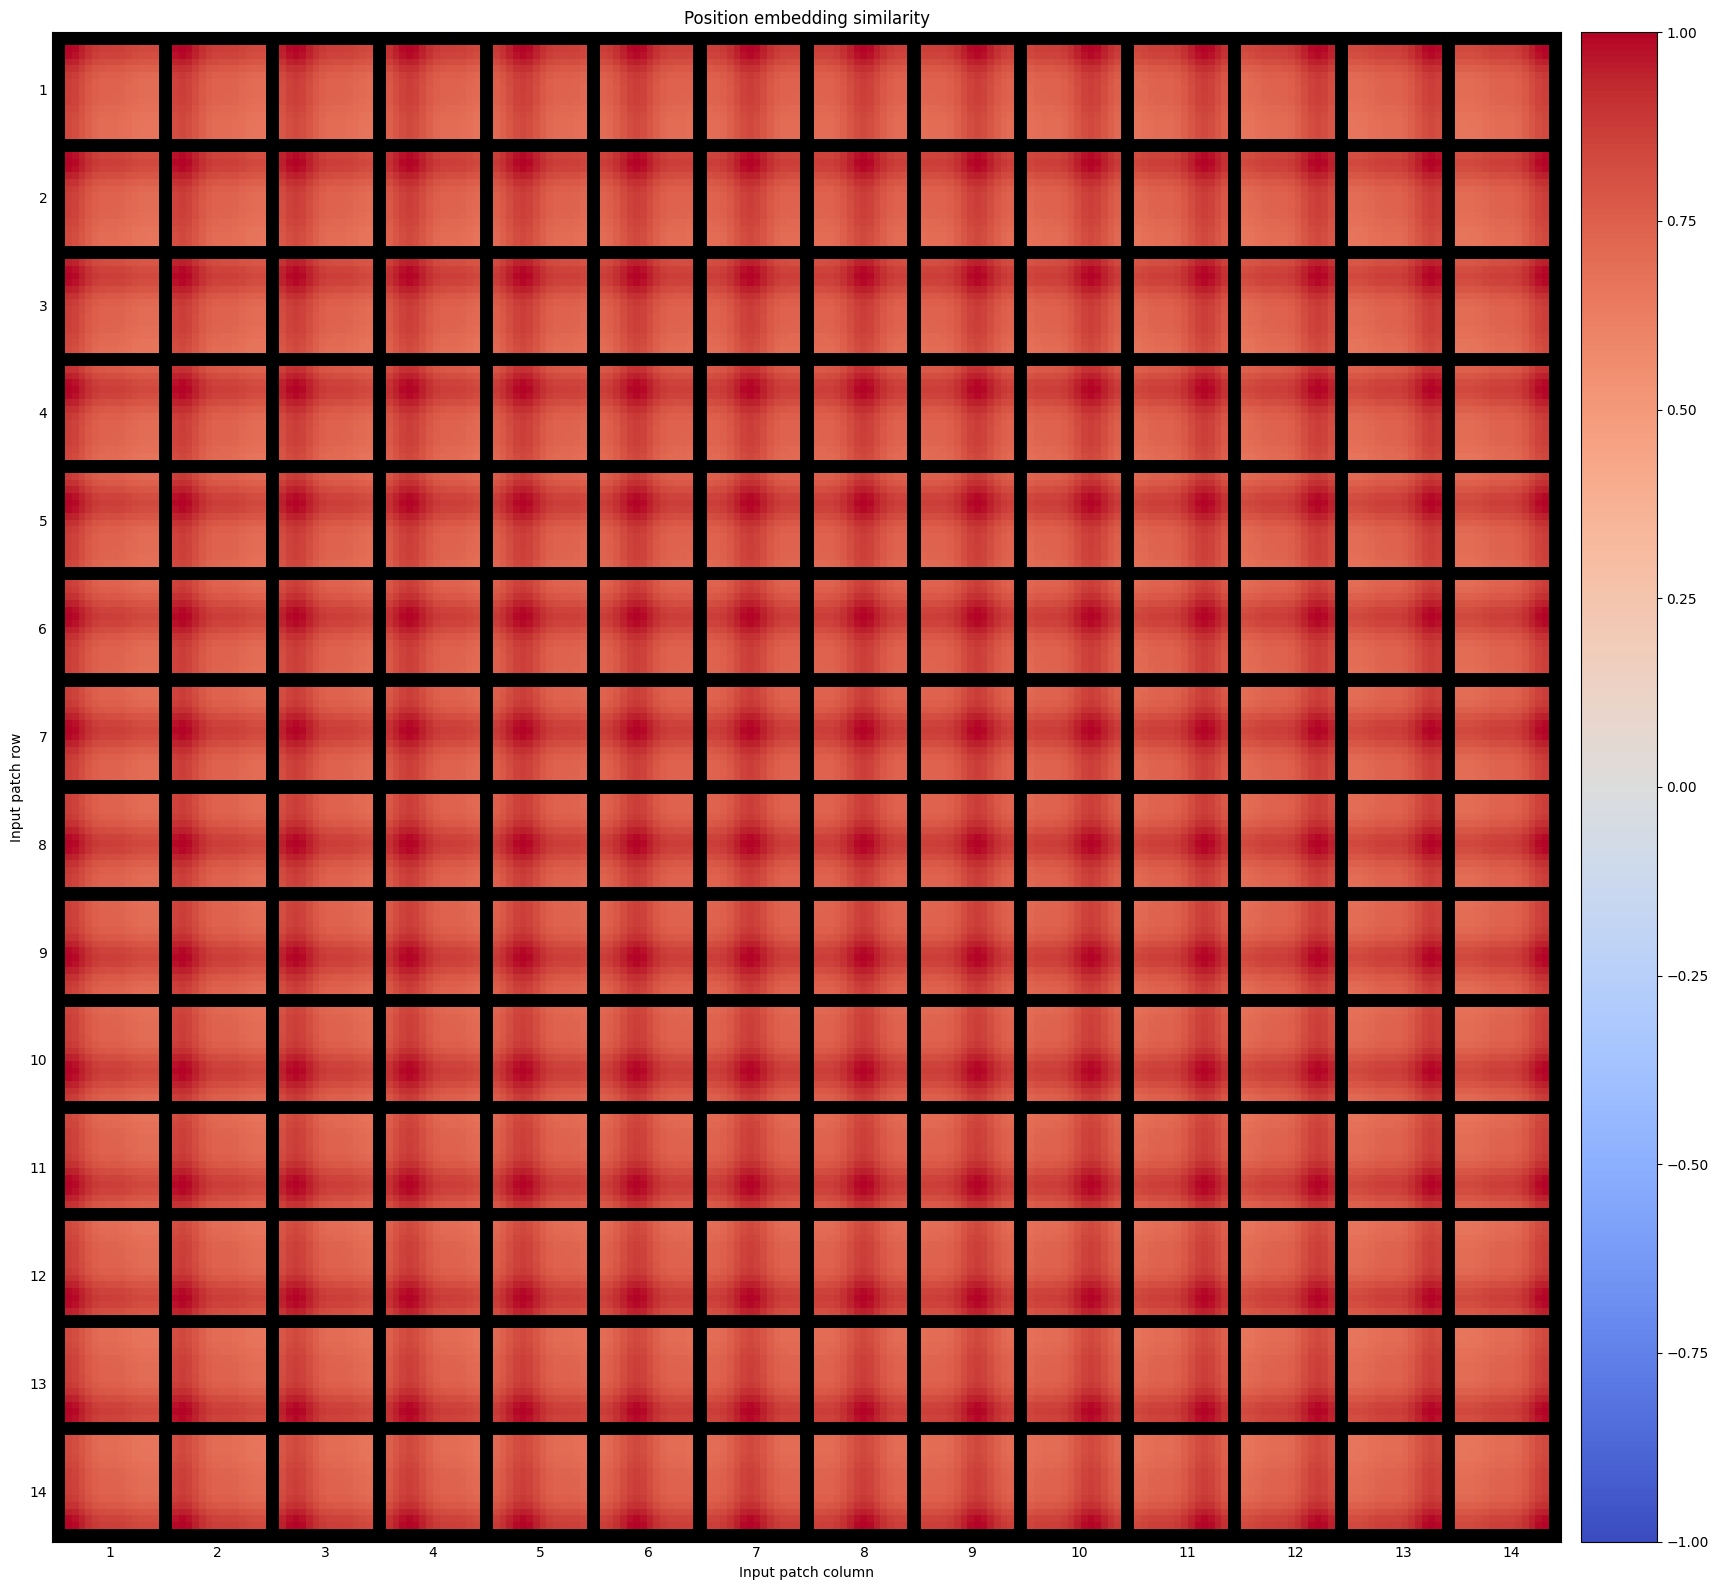

In [11]:
image = grid[0]

def plot_position_embeddings(colormap):
    fig, axis = plt.subplots(figsize=(18, 16))

    im = axis.imshow(image, interpolation='none', cmap=colormap, vmin=-1, vmax=1)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.2)

    height, width = image.shape

    offset = width / num_tokens_x / 2
    tick_positions = np.linspace(offset, width - offset, num_tokens_x)
    tick_labels = [str(i + 1) for i in range(num_tokens_x)]
    axis.set_xticks(tick_positions)
    axis.set_xticklabels(tick_labels)
    axis.tick_params(axis='x', length=0)

    offset = height / num_tokens_y / 2
    tick_positions = np.linspace(offset, width - offset, num_tokens_y)
    tick_labels = [str(i + 1) for i in range(num_tokens_y)]
    axis.set_yticks(tick_positions)
    axis.set_yticklabels(tick_labels)
    axis.tick_params(axis='y', length=0)

    axis.set_title('Position embedding similarity')
    axis.set_xlabel('Input patch column')
    axis.set_ylabel('Input patch row')

    fig.colorbar(im, cax=cax)
    fig.tight_layout()

# Use colors in the paper
plot_position_embeddings('viridis')

# Use better colors
cmap = mpl.colormaps.get_cmap('coolwarm')
cmap.set_bad(color='black')
plot_position_embeddings(cmap)